# SPECFEM Users Workshop -- Day 3 (Oct. 7, 2022)

## Part 3b: Seismic Imaging Exercise  

- In this notebook we perform a multi-event, multi-station 2D inversion
- We will perform all book keeping tasks manually, from running forward simulations to running adjoint simulations  
- **Objective**: Heavy-handidly illustrate the laborious book keeping required as inversion problems scale, prompting the need for automated tools    
- These instructions should be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_3a_imaging_adv.ipynb
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging_adv.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_0_container_testing.ipynb
- Day 1A Notebook (Intro SPECFEM): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem2d.ipynb
- Day 1B Notebook (Fwd. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb
- Day 2A Notebook (Adj. Simulations): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_2a_kernels.ipynb
- Day 3A Notebook (Simple Imaging): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_3a_imaging_simple.ipynb


**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.

----------------

# A Multi-event, Multi-station Inversion

- Real seismic inversions use multiple events recorded at multiple stations to increase coverage and reduce nonuniqueness
- Here we attempt a *multi-event* ($N=10$), multi-station ($S=10$) model update with the skills we have picked up in previous notebooks
- The inversion workflow is as follows: 
    0) **data**: run $N$ forward simulations to generate *data* using target model ($m_{true}$) for $N$ events and $S$ stations
    1) **synthetics**: run $N$ forward simulations to generate synthetics through starting model ($m_{init}$) for $N$ events and $S$ stations
    2) **misfit**: quantify data-synthetic misfit ($\chi_{init}$) and generate adjoint sources for each source-receiver pair ($N\times S$ waveforms)
    3) **kernels**: generate misfit kernels with $N$ adjoint simulation
    4) **update**: scale gradient and update initial model to get trial model: $m_{try}$
    5) **line search**: run $N$ forward simulations using trial model $m_{try}$ to get $N \times S$ new synthetic waveforms
    6) **line search**: calculate misfit ($\chi_{try}$) and determine if misfit is reduced ($\chi_{try} < \chi_{init}$?)
    7) **line search**: if misfit is not reduced ($\chi_{try} >=  \chi_{init}$), repeat steps 5-7 with newly scaled gradient
    8) **line search**: if misfit is reduced, accept trial model as newly updated model ($m_{try} \rightarrow m_{01}$)
    9) **finalize**: set newly updated model as initial model ($m_{01} \rightarrow m_{init}$) and repeat steps 1-9

In [1]:
# Python packages we might need for today's notebook. You are welcome to import more as you see fit
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Image
from scipy.integrate import simps
from seisflows.tools.specfem import Model, read_fortran_binary, write_fortran_binary

## 1) Set Up a SPECFEM2D Working Directory

- We want to set up a clean working directory to run SPECFEM2D. This will help us preserve our cloned repository and reduce file clutter  
- During this example we will use: 10 sources, 10 receivers
- *Starting model*: homogeneous halfspace  
- *Target model*: perturbation checkerboard  
- **Objective**: Generate a misfit kernel and manually update a 2D model, quantify misfit 
- **NOTE:** We will work in `/home/scoped/work/day_3/inversion_example`. The following cells assume relative paths, so you must evaluate the '%cd' command below.

In [2]:
# Make sure we're in an empty working directory
! rm -rf /home/scoped/work/day_3/inversion_example
! mkdir -p /home/scoped/work/day_3/inversion_example
%cd /home/scoped/work/day_3/inversion_example

# Setup SPECFEM2D working directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

/home/scoped/work/day_3/inversion_example


### 1a) Visualize Experimental Setup

- We plot the 10 sources and 10 receivers on top of the checkerboard model for context  
- The initial model is a homogeneous halfspace, and is **not** plotted here

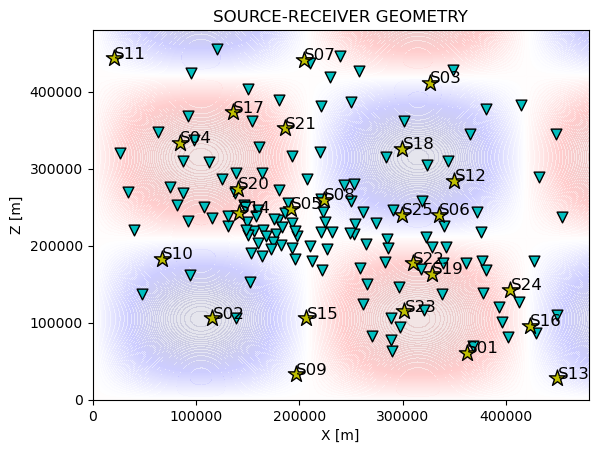

In [3]:
def plot_sources_receivers(nevents=25):
    """
    Small code block to plot source-receiver geometry with text labels
    Assumes relative pathing
    """
    # Grab Station locations
    sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T
    
    # Grab Event locations
    ev_x, ev_z = [], []
    for i in range(1, nevents+1):
        source_file = f"DATA/SOURCE_{i:0>3}"
        with open(source_file, "r") as f:
            lines = f.readlines()
        # Trying to break apart the following line
        # 'xs = 299367.72      # source location x in meters\n'
        xs = float(lines[2].split("=")[1].split("#")[0].strip())
        zs = float(lines[3].split("=")[1].split("#")[0].strip())

        ev_x.append(xs)
        ev_z.append(zs)
        
    # Plot SOURCES and STATIONS geometry
    for i, (x, z) in enumerate(zip(sta_x, sta_z)):
        plt.scatter(x, z, c="c", marker="v", s=60, edgecolor="k")
        # plt.text(x, z, f"R{i:0>2}", fontsize=12)
    for i, (x, z) in enumerate(zip(ev_x, ev_z)):
        plt.scatter(x, z, c="y", marker="*", edgecolor="k", s=150)
        plt.text(x, z, f"S{i+1:0>2}", fontsize=12, c="k")  # SOURCE numbering starts at 1
    
    # Finalize plot labels
    plt.xlabel("X [m]")
    plt.ylabel("Z [m]")
    plt.xlim([0, 480E3])
    plt.ylim([0, 480E3])
    plt.title("SOURCE-RECEIVER GEOMETRY")
    
    
# Load and plot checkerboard model
data = np.genfromtxt("DATA/model_velocity.dat_checker", dtype=float, usecols=[1,2,4,5])
chkbd_x, chkbd_z, chkbd_vp, chkbd_vs = data.T
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vp, levels=125, cmap="seismic_r", alpha=0.1)

# Plot sources and receivers on top
plot_sources_receivers()
plt.show()

-----------
## 2) Target Model (checkerboard) Synthetics 

- We'll use the Target checkerboard model used to generate 'data'
- Let's first visualize it to help us contexualize the problem  

### 2a) Set up the Target Model
- We want to set up our forward simulations here  
- We'll be using the Checkerboard model to generate 'data'  

#### **TASKS TO COMPLETE**:
1) Set the correct `DATA/Par_file` for the checkerboard model (*remember* that the checkerboard model parameters are defined in `Par_file_Tape2007_132rec_checker`)
2) Tell SPECFEM to save our model in FORTRAN binary format (in the `Par_file`)  
3) Tell SPECFEM to save our DATABASE files in FORTRAN binary format (in the `Par_file`)  
4) Tell SPECFEM to use our existing STATIONS file, rather than it's own internal definition (in the `Par_file`)  
5) Set the number of time steps (NSTEP) to 5000  
6) Set the correct naming convention for our checkerboard model, which is currently named `model_velocity.dat_checker` (see Notebook 2A Section 3A)
7) Create a STATIONS file with 10 stations (easiest solution is to copy the first ten lines of `STATIONS_checker`)  

In [4]:
%cd /home/scoped/work/day_3/inversion_example

# Set up the Par_file
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file NSTEP 5000  # 4800 -> 5000 to match the other Par_file

# Ensure that we're using stations 1-10
! head -10 DATA/STATIONS_checker > DATA/STATIONS  

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

/home/scoped/work/day_3/inversion_example
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .true. -> .true.
NSTEP: 4800 -> 5000


### 2b) Run the Forward Solver

- We want to run 10 simulations to generate 10 sets of target data  
- That means we need to run the forward solver **once** per event (i.e., 10 times)
- *Remember* that each time we run SPECFEM, it overwrites existing files in the OUTPUT_FILES/ directory

#### **TASK TO COMPLETE:**

- Run the mesher and solver for **ten** (10) different events  
- Use SOURCE_001 -> SOURCE_010 (or any ten sources of your choosing)  
- Only use **one** core when running the mesher and solver  
- After each solver run, make sure you **store** your synthetic seismograms somewhere they can't be overwritten


In [5]:
def run_fwd_mesher_solver(ntask, save_synthetics, save_forward=False):
    """
    Run the mesher and solver `ntask` times. Save the resulting synthetics
    to path `save_synthetics`. Assumes relative pathing.
        
    :type ntask: int
    :param ntask: number of sources to run
    :type save_synthetics: str
    :param save_synthetics: relative directory name to save synthetics to
    """
    print(f"Generating synthetics for {ntask} sources")
    
    # Run `ntask` forward simulations using Target model, generating 'data' for S stations. 
    for i in range(1, ntask + 1):
        # Select the task/source to run mesher/sovler with
        source_fid = f"SOURCE_{i:0>3}"
        source_path = f"DATA/{source_fid}"
        print(f"Running mesher and solver for {source_fid}")

        # Set the correct source for SPECFEM to find
        if os.path.exists("DATA/SOURCE"):
            os.remove("DATA/SOURCE")
        shutil.copy(source_path, "DATA/SOURCE")

        # Run xmeshfem and xspecfem 
        ! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
        ! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

        # Move the just-generated synthetic waveforms so they don't get overwritten
        synthetics_dir = os.path.join(source_fid, save_synthetics)
        if os.path.exists(synthetics_dir):
            shutil.rmtree(synthetics_dir)
        os.makedirs(synthetics_dir)
        for src in glob("OUTPUT_FILES/*.semd"):
            dst = os.path.join(source_fid, save_synthetics, os.path.basename(src))
            os.rename(src, dst)
        
        # Save forward arrays stored on disk if requested
        if save_forward:
            print(f"saving forward arrays {source_fid}")
            save_fwd_dir = os.path.join(source_fid, "SAVE_FORWARD")
            if not os.path.exists(save_fwd_dir):
                os.makedirs(save_fwd_dir)
            # Save fwd arrays are the last frame and boundary conditions
            fid_templates = ["lastframe_elastic*.bin", "absorb_elastic_*.bin"]
            for fid in fid_templates:
                for src in glob(f"OUTPUT_FILES/{fid}"):
                    dst = os.path.join(save_fwd_dir, os.path.basename(src))
                    os.rename(src, dst)
        
    print("Finished generating synthetics")
    
# Run the function we just defined
run_fwd_mesher_solver(ntask=10, save_synthetics="TARGET", save_forward=False)

Generating synthetics for 10 sources
Running mesher and solver for SOURCE_001
Running mesher and solver for SOURCE_002
Running mesher and solver for SOURCE_003
Running mesher and solver for SOURCE_004
Running mesher and solver for SOURCE_005
Running mesher and solver for SOURCE_006
Running mesher and solver for SOURCE_007
Running mesher and solver for SOURCE_008
Running mesher and solver for SOURCE_009
Running mesher and solver for SOURCE_010
Finished generating synthetics


----------
## 3) Initial Model Synthetics

- Now let's generate synthetics through a homogeneous halfspace initial model  
- **IMPORTANT**: We need to save the forward wavefield (parameter `SAVE_FORWARD`) from the forward simulation of each $N$ events  
- *Reminder:* The saved forward wavefield is a snapshot of the forward wavefield at the last time step  

### 3a) Set up the Initial Model
- We want to set up our forward simulations here  
- We'll be using the homogeneous halfspace model to generate synthetics    

#### **TASKS TO COMPLETE:**
1) Set the correct `Par_file` for the homogeneous halfspace (*remember* homogeneous halfspace is defined by `Par_file_Tape2007_onerec`)
2) Tell SPECFEM to save our model in FORTRAN binary format (in the `Par_file`)  
3) Tell SPECFEM to save our DATABASE files in FORTRAN binary format (in the `Par_file`)  
4) Tell SPECFEM to use our existing STATIONS file, rather than it's own internal definition (in the `Par_file`)  
5) Tell SPECFEM to **save** the forward wavefield after our simulation

In [6]:
# Re-set the SPECFEM2D Par_file which is set up for the Initial model
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Edit Par_file to get the correct output files for Initial model
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_forward .true.

SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1
use_existing_STATIONS: .false. -> .true.
SAVE_FORWARD: .false. -> .true.


### 3b) Run the Forward Solver

- We want to run 10 simulations to generate 10 sets of synthetics
- That means we need to run the forward solver **once** per event (i.e., 10 times)
- *Remember* that each time we run SPECFEM, it overwrites existing files in the OUTPUT_FILES/ directory

#### **TASK TO COMPLETE:**

- Run the mesher and solver for **ten** (10) different events  
- Use the **same** events that you used in Section 2
- Only use **one** core when running the mesher and solver  
- After each solver run, make sure you **store** your synthetic seismograms somewhere they can't be overwritten
- Also make sure to **store** the forward wavefield which has been output by SPECFEM  

In [7]:
# Run mesher and solver for the Target model and 10 sources. 
# Also save forward arrays for subsequent adjoint simulations
run_fwd_mesher_solver(ntask=10, save_synthetics="SYNTHETIC", save_forward=True)

Generating synthetics for 10 sources
Running mesher and solver for SOURCE_001
saving forward arrays SOURCE_001
Running mesher and solver for SOURCE_002
saving forward arrays SOURCE_002
Running mesher and solver for SOURCE_003
saving forward arrays SOURCE_003
Running mesher and solver for SOURCE_004
saving forward arrays SOURCE_004
Running mesher and solver for SOURCE_005
saving forward arrays SOURCE_005
Running mesher and solver for SOURCE_006
saving forward arrays SOURCE_006
Running mesher and solver for SOURCE_007
saving forward arrays SOURCE_007
Running mesher and solver for SOURCE_008
saving forward arrays SOURCE_008
Running mesher and solver for SOURCE_009
saving forward arrays SOURCE_009
Running mesher and solver for SOURCE_010
saving forward arrays SOURCE_010
Finished generating synthetics


-------------
## 4) Quantify Misfit, Generate Adjoint Sources for Initial Model

- We want to quantify misfit for all $N \times S$ waveforms
- We also want to generate $N \times S$ adjoint sources for subsequent adjoint simulations
- We'll use a waveform difference misfit for simplicity
- Misfit: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~$
- Adjoint Source: $f^\dagger (t) = s(t) - d(t)$

### 4a) Quantify Misfit and Generate Adjoint Sources

#### **TASKS TO COMPLETE:**

1) For a given **event** and for each **station** load in 'data' and synthetics  
2) Calculate the misfit value: $ \chi = \frac{1}{2} \int [d(t)-s(t)]^2 dt~$, and store its value in a text file (e.g., *'source_001_misfit_initial_model.txt'*)  
3) Calculate the adjoint source: $f^\dagger (t) = s(t) - d(t)$
4) Save the adjoint source with the correct format (ASCII) and the correct filename  
5) Store adjoint sources per-event (i.e., SOURCE_001 should have it's own directory of adjoint sources)  
6) Optional: Plot data and synthetics alongside adjoint sources  

In [8]:
def quantify_misfit_single(data_fid, syn_fid): 
    """
    Quantify misfit and generate adjoint source w/ waveform difference
    For a single source-receiver pair
    
    :type data_fid: str
    :param data_fid: filename and path to data array
    :type syn_fid: str
    :param syn_fid: filename and path to synthetic array
    """
    # Load data into NumPy arrays
    t_data, d_data = np.loadtxt(data_fid).T
    t_syn, d_syn = np.loadtxt(syn_fid).T
    
    # dt represents the time step
    dt = t_syn[1] - t_syn[0] 
    
    # Calculate waveform difference misfit
    misfit = 1/2 * simps((d_data - d_syn)**2, dx=dt)
    
    # Create the time-amplitude array for adjoint source
    d_adj = d_data - d_syn
    adj_src = np.vstack((t_syn, d_adj)).T
    
    return misfit, adj_src    


def quantify_misfit(misfit_file, write_adjsrc, syn_dir="SYNTHETIC"):
    """
    Quantify Misfit for all sources available
    
    :type write_misfit: str
    :param write_misfit: file name to write misfit to
    :type write_adjsrc: bool
    :param write_adjsrc: choose whether or not to save adjoint sources
    :type syn_dir: str
    :param syn_dir: relative path to directory where synthetics are stored
    """
    for src in sorted(glob("SOURCE_???")):
        print(f"Quantifying misfit for {src}")

        # Set up directories to store misfit and adjoint sources
        # Make sure we're writing to fresh files/directories
        misfit_path = os.path.join(src, misfit_file)
        if os.path.exists(misfit_path):
            os.remove(misfit_path)
                
        if write_adjsrc:
            adj_src_dir = os.path.join(src, "ADJOINT_SOURCES")
            if os.path.exists(adj_src_dir):
                shutil.rmtree(adj_src_dir)
            os.makedirs(adj_src_dir)

        # Loop through each of the synthetic waveforms to get file names
        for syn_fid in sorted(glob(os.path.join(src, syn_dir, "*"))):
            # e.g., AA.S000001.BXY.semd
            fid_base = os.path.basename(syn_fid)
            data_fid = os.path.join(src, "TARGET", fid_base)
            
            misfit, adj_src = quantify_misfit_single(data_fid, syn_fid)
            print(f"\t{fid_base}; MISFIT={misfit:.3E}")
            
            # Write misfit to file
            with open(misfit_path, "a") as f:
                f.write(f"{misfit}\n")

            # Write adjoint source to file
            # Note that SPECFEM expects adjoint sources to be suffixed '.adj.
            if write_adjsrc:
                np.savetxt(os.path.join(adj_src_dir, fid_base.replace("semd", "adj")), adj_src)
                
def plot_waveforms(t, data, labels, colors):
    """Re-usable function to plot synthetic waveforms"""
    for i, d in enumerate(data):
        plt.plot(t, d, c=colors[i], label=labels[i])
    plt.xlabel("Time [s]")
    plt.ylabel("Displacement [m]")
    plt.legend()  
    
# Run misfit quantification for initial model
quantify_misfit(misfit_file="MISFIT_INIT.txt", write_adjsrc=True, syn_dir="SYNTHETIC")

Quantifying misfit for SOURCE_001
	AA.S000000.BXY.semd; MISFIT=1.453E-03
	AA.S000001.BXY.semd; MISFIT=2.779E-03
	AA.S000002.BXY.semd; MISFIT=2.681E-03
	AA.S000003.BXY.semd; MISFIT=3.362E-03
	AA.S000004.BXY.semd; MISFIT=1.865E-03
	AA.S000005.BXY.semd; MISFIT=3.019E-03
	AA.S000006.BXY.semd; MISFIT=6.479E-04
	AA.S000007.BXY.semd; MISFIT=3.854E-03
	AA.S000008.BXY.semd; MISFIT=1.535E-03
	AA.S000009.BXY.semd; MISFIT=2.521E-03
Quantifying misfit for SOURCE_002
	AA.S000000.BXY.semd; MISFIT=7.489E-04
	AA.S000001.BXY.semd; MISFIT=2.291E-05
	AA.S000002.BXY.semd; MISFIT=1.178E-04
	AA.S000003.BXY.semd; MISFIT=5.811E-04
	AA.S000004.BXY.semd; MISFIT=7.057E-04
	AA.S000005.BXY.semd; MISFIT=3.858E-04
	AA.S000006.BXY.semd; MISFIT=2.904E-04
	AA.S000007.BXY.semd; MISFIT=4.175E-04
	AA.S000008.BXY.semd; MISFIT=6.777E-05
	AA.S000009.BXY.semd; MISFIT=7.442E-04
Quantifying misfit for SOURCE_003
	AA.S000000.BXY.semd; MISFIT=1.634E-03
	AA.S000001.BXY.semd; MISFIT=1.572E-03
	AA.S000002.BXY.semd; MISFIT=2.182E-04
	

#### Understanding misfit quantification
- For each of our $N$ sources we have quantified misfit for $S$ stations
- Each synthetic has a corresponding adjoint source, which is stored in `SOURCE_???/ADJOINT_SOURCE`
- Each adjoint source is equal to the waveform difference between data and synthetic
- Each adjoint source has a corresponding misfit value
- Misfit values are stored in a text file which can be summed to calculate the overall **event misfit**
- The adjoint sources will be used to run $N$ adjoint simulations
- The misfit value will be used to determine if misfit is reduced during the line search

In [9]:
# We can take a look at the files we just created
! ls SOURCE_001
! echo 
! echo "> ADJOINT SOURCES"
! ls SOURCE_001/ADJOINT_SOURCES
! echo 
! echo "> SOURCE_001/ADJOINT_SOURCES/AA.S000000.BXY.adj"
! head SOURCE_001/ADJOINT_SOURCES/AA.S000000.BXY.adj
! echo
! echo "> SOURCE_001/MISFIT_INIT.txt"
! head SOURCE_001/MISFIT_INIT.txt

ADJOINT_SOURCES  MISFIT_INIT.txt  SAVE_FORWARD	SYNTHETIC  TARGET

> ADJOINT SOURCES
AA.S000000.BXY.adj  AA.S000003.BXY.adj	AA.S000006.BXY.adj  AA.S000009.BXY.adj
AA.S000001.BXY.adj  AA.S000004.BXY.adj	AA.S000007.BXY.adj
AA.S000002.BXY.adj  AA.S000005.BXY.adj	AA.S000008.BXY.adj

> SOURCE_001/ADJOINT_SOURCES/AA.S000000.BXY.adj
-4.800000000000000000e+01 0.000000000000000000e+00
-4.793999999999999773e+01 0.000000000000000000e+00
-4.788000000000000256e+01 0.000000000000000000e+00
-4.782000000000000028e+01 0.000000000000000000e+00
-4.775999999999999801e+01 0.000000000000000000e+00
-4.770000000000000284e+01 0.000000000000000000e+00
-4.764000000000000057e+01 0.000000000000000000e+00
-4.757999999999999829e+01 0.000000000000000000e+00
-4.752000000000000313e+01 0.000000000000000000e+00
-4.746000000000000085e+01 0.000000000000000000e+00

> SOURCE_001/MISFIT_INIT.txt
0.0014528338515827628
0.0027791449963558233
0.0026805867007072
0.003362180404050814
0.0018646699327360783
0.003018752702325197
0.0006

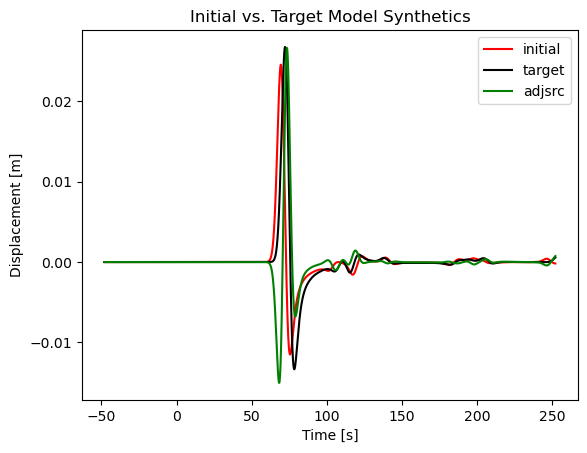

In [10]:
# Plot an example of data, synthetic and adjoint source
t_init, d_init = np.loadtxt("SOURCE_001/SYNTHETIC/AA.S000000.BXY.semd").T
t_true, d_true = np.loadtxt("SOURCE_001/TARGET/AA.S000000.BXY.semd").T
t_adjs, d_adjs = np.loadtxt("SOURCE_001/ADJOINT_SOURCES/AA.S000000.BXY.adj").T

plot_waveforms(t=t_init, data=[d_init, d_true, d_adjs],
               labels=["initial", "target", "adjsrc"],
               colors=["r", "k", "g"])

plt.title("Initial vs. Target Model Synthetics")
plt.show()

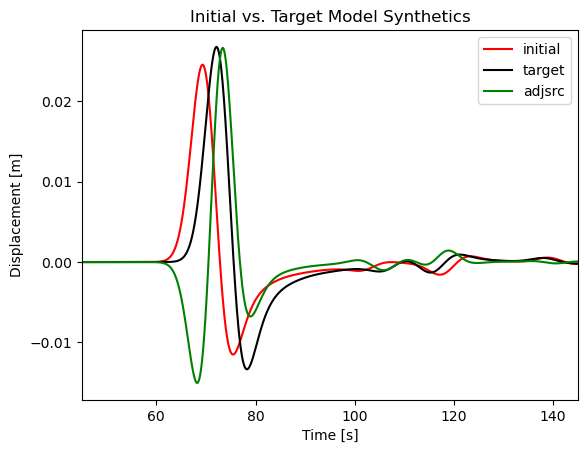

In [11]:
plot_waveforms(t=t_init, data=[d_init, d_true, d_adjs],
               labels=["initial", "target", "adjsrc"],
               colors=["r", "k", "g"])
plt.xlim([45,145])
plt.title("Initial vs. Target Model Synthetics")
plt.show()

--------
## 5) Run Adjoint Simulations for Event Kernels

- Now we need to run the adjoint simulations to generate event kernels
- *Remember* that event kernels tell us what parts of the model are sensitive to the misfit function for **EACH** event
- **NOTE**: We need to place the adjoint sources in the correct location and also tell SPECFEM that we are running an adjoint simulation
- SPECFEM expects adjoint sources in the `SEM/` directory, and formatted exactly the same as its output synthetics

#### **TASKS TO COMPLETE:** 

1) For a given SOURCE that you used to run your forward simulations  
2) Make sure that the correct SOURCE is set in the *DATA/* directory  
3) Create a '*SEM/*' directory and make sure the correct adjoint sources are linked  
4) Make sure the correct forward wavefield (from *save_forward*) is accesible in the 'OUTPUT_FILES/' directory 
5) Tell SPECFEM that we want to run an adjoint simulation (*simulation_type*)
6) Run the adjoint solver with 1 core
7) Store the output kernel files (*\*_kernel.bin*) somewhere safe so they are not overwritten by your next simulation  
7) Repeat steps 1-6 for all other SOURCES used for your forward simulations  

In [12]:
def run_adj_solver():
    """
    Counterpart to `run_fwd_mesher_solver`, runs adjoint simulations for `ntask` events
    and saves the resulting kernels. Assumes relative paths
    """
    ntask = len(glob("SOURCE_???"))
    print(f"Running adjoint simulations for {ntask} events")
    
    for i in range(1, ntask + 1):
        # Choose the task/source to run mesher/sovler with
        source_fid = f"SOURCE_{i:0>3}"
        source_path = f"DATA/{source_fid}"
        print(f"Running adjoint simulation for {source_fid}")

        # Set the correct source for SPECFEM to find
        if os.path.exists("DATA/SOURCE"):
            os.remove("DATA/SOURCE")
        shutil.copy(source_path, "DATA/SOURCE")
                
        # Symlink adjoint sources so SPECFEM can find them
        if os.path.islink("SEM"):
            os.remove("SEM")
        os.symlink(os.path.join(source_fid, "ADJOINT_SOURCES"), "SEM")
        
        # Copy the saved forward array so that SPECFEM can find it
        for src in glob(os.path.join(source_fid, "SAVE_FORWARD", "*")):
            dst = os.path.join("OUTPUT_FILES", os.path.basename(src))
            if os.path.exists(dst):
                os.remove(dst)
            shutil.copy(src, dst)
            
        # Run the adjoint simulation
        ! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/adjoint_solver.txt
        
        # Move the resulting event kernel to disk
        kernel_dir = os.path.join(source_fid, "KERNELS")
        if os.path.exists(kernel_dir):
            shutil.rmtree(kernel_dir)
        os.makedirs(kernel_dir)
        for src in glob("OUTPUT_FILES/*kernel.bin"):
            dst = os.path.join(kernel_dir, os.path.basename(src))
            os.rename(src, dst)
            
    print("Finished")
    
# Set up the Par_file to run an adjoint simulation (type 3) 
# and output kernels in expected output (FORTRAN binary)
! seisflows sempar -P DATA/Par_file simulation_type 3
! seisflows sempar -P DATA/Par_file save_ASCII_kernels .false.

# Run adjoint simluation for each N sources. This may take a while
run_adj_solver()

SIMULATION_TYPE: 1 -> 3
save_ASCII_kernels: .true. -> .false.
Running adjoint simulations for 10 events
Running adjoint simulation for SOURCE_001
Running adjoint simulation for SOURCE_002
Running adjoint simulation for SOURCE_003
Running adjoint simulation for SOURCE_004
Running adjoint simulation for SOURCE_005
Running adjoint simulation for SOURCE_006
Running adjoint simulation for SOURCE_007
Running adjoint simulation for SOURCE_008
Running adjoint simulation for SOURCE_009
Running adjoint simulation for SOURCE_010
Finished


----------
## 6) Sum Event Kernels 

- Now we have $N$=10 event kernels, each representing misfit sensitivity for each of the $N$ events
- We need to sum the *event kernels* into a *misfit kernel*, which represents misfit sensitivity for **all** $N$ events
- We can use the `xcombine_sem` executable to sum these kernels into the **gradient**

#### **TASK TO COMPLETE**:

- Combine the `alpha` and `beta` kernels for **all** ten events using the executable `xcombine_sem`
- Remember that the command line call of `xcombine_sem` is:

```bash
mpirun -n NPROC bin/xcombine_sem KERNEL_NAMES INPUT_FILE OUTPUT_DIR
```

Where:
- `KERNEL_NAMES`: the name of the kernels you want to smooth, corresponding to the filenames (e.g., proc000000_alpha_kernel.bin corresponds to 'alpha_kernel')    
- `INPUT_FILE`: a text file that lists the full paths to **all** your kernel files. You should have 10 lines per kernel name since we have 10 events  
- `OUTPUT_DIR`: a directory where SPECFEM can output the **gradient**    

In [13]:
# First we need to tell SPECFEM where all our kernel files are by 
# listing paths in an input file
with open("kernel_paths.txt", "w") as f:
    for fid in sorted(glob("SOURCE_???/KERNELS")):
        f.write(f"{os.path.abspath(fid)}\n")

# Make a directory to store gradient files
! mkdir GRADIENT

# mpirun -n NPROC bin/xcombine_sem KERNEL_NAMES INPUT_FILE OUTPUT_DIR*
! mpirun -n 1 bin/xcombine_sem alpha_kernel,beta_kernel kernel_paths.txt GRADIENT 

# Rename 'alpha' to Vp and 'beta' to Vs for easier name recognition
for src in glob("GRADIENT/*"):
    if "alpha" in src:
        os.rename(src, src.replace("alpha", "vp"))
    elif "beta" in src:
        os.rename(src, src.replace("beta", "vs"))

 Running XCOMBINE_SEM

 reading in array for: alpha_kernel
                1  out of           10
 reading in array for: alpha_kernel
                2  out of           10
 reading in array for: alpha_kernel
                3  out of           10
 reading in array for: alpha_kernel
                4  out of           10
 reading in array for: alpha_kernel
                5  out of           10
 reading in array for: alpha_kernel
                6  out of           10
 reading in array for: alpha_kernel
                7  out of           10
 reading in array for: alpha_kernel
                8  out of           10
 reading in array for: alpha_kernel
                9  out of           10
 reading in array for: alpha_kernel
               10  out of           10
 writing sum: alpha_kernel

 reading in array for: beta_kernel
                1  out of           10
 reading in array for: beta_kernel
                2  out of           10
 reading in array for: beta_kernel
                

#### Visualizing the Event Kernel

- Gradient amplitudes are stored in the output Fortran binary files
- We only plot the Vs Kernel here but the Gradient is a linear array of Vp and Vs

Text(0.5, 1.0, 'Gradient Vs')

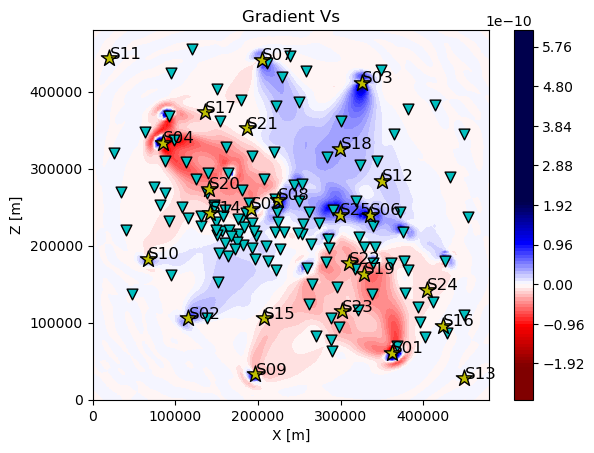

In [14]:
# In this cell we'll scale the gradient (Vp and Vs only) by GTG^-1
x = read_fortran_binary("DATA/proc000000_x.bin")
z = read_fortran_binary("DATA/proc000000_z.bin")
vs_kernel = read_fortran_binary("GRADIENT/proc000000_vs_kernel.bin")

boundary_value = 2E-10  # <- change this value to adjust the colorscale

# Plot the kernel
plt.tricontourf(x, z, vs_kernel, levels=125, cmap="seismic_r", 
                vmin=-1*boundary_value, vmax=boundary_value)
plt.colorbar()

plot_sources_receivers()
plt.title("Gradient Vs")

#### Understanding the above figure

- Above we are seeing the **misfit kernel** for the parameter Vs  
- The misfit kernel represents sensitivity of the misfit function to changes in model parameter Vs  
- Red colors tell us that the inital model is **too fast** (i.e., we need to slow down the initial model)  
- Blue colors tell us that the initial model is **too slow** (i.e., we need to speed up the initial model)  
- We can see large amplitudes directly around source locations (e.g., S01 and S09 at the bottom)  
- These amplitudes are due to the numerical discretization of our grid, and the fact that we implement point source forces  
- We can use regularization (smoothing) to remove the strong influence of the near-source region  

----------
## 7) Smoothing/Regularizing Gradient

- We want to use regularization to smooth out the gradient to get a more conservative picture of model updates  
- We use the `xsmooth_sem` executable to smooth our kernels  
- We should choose smoothing length based on the shortest period of our data  
- Because we know the target model, we smooth conservatively to the length scale of the checkerboards ($\Gamma$=50km)  
- The SPECFEM smoothing code convolves the kernel with a Gaussian. We are allowed to choose the half-width of the Gaussian  
- The relationship between half-width and full-width is $\Gamma\approx2.355\sigma$, so we choose $\sigma$=20km  

 The usage of `xsmooth_sem` is given as
 ```bash
 USAGE:  mpirun -np NPROC bin/xsmooth_sem SIGMA_H SIGMA_V KERNEL_NAME INPUT_DIR OUPUT_DIR GPU_MODE
 ```
 We will need to choose values and directories to make this work
  - `SIGMA_H`: Horizontal smoothing length [m] representing the horizontal half-width of the Gaussian  
  - `SIGMA_Z`: Vertical smoothing length [m] representing the vertical half-width of the Gaussian  
  - `KERNEL_NAME`: The name of the kernel we want to smooth. Must match filename, so `proc000000_vs_kernel.bin` will correspond to kernel name `vs_kernel`  
  - `INPUT_DIR`: where SPECFEM can find the kernel files
  - `OUTPUT_DIR`: Where SPECFEM should output the SMOOTHED kernels 
  - `GPU_MODE`: Use GPU acceleration to speed up the smoothing operation (.true. or .false.)
  
#### **TASKS TO COMPLETE:**

1) Make sure all your model files (located in *DATA/\*.bin*) and gradient files (located where `xcombine_sem` outputted them) are in the same place 
2) Smooth your `alpha` and `beta` kernels by 20km in the horizontal and vertical directions  
3) Remember to keep track of your smoothed and raw gradient. We will proceed with our **smoothed** gradient  

 Running XSMOOTH_SEM on           1 processors
 command line arguments:
   smoothing sigma_h , sigma_v                :    20000.0000       20000.0000    
   smoothing scalelengths horizontal, vertical:    56568.5430       56568.5430    
   input dir : DATA/
   output dir: GRADIENT/


 Scaling values: min/max =    628318528.       2.51327462E+09
 written: GRADIENT//proc000000_vs_kernel_smooth.bin

  Min / Max data value before smoothing =    1.80248611E-18   6.13813556E-10 for vs_kernel
  Min / Max data value after smoothing  =    3.76721791E-18   5.28358850E-11 for vs_kernel
 Computation time with CPU:   8.89161587    
 Running XSMOOTH_SEM on           1 processors
 command line arguments:
   smoothing sigma_h , sigma_v                :    20000.0000       20000.0000    
   smoothing scalelengths horizontal, vertical:    56568.5430       56568.5430    
   input dir : DATA/
   output dir: GRADIENT/


 Scaling values: min/max =    628318528.       2.51327462E+09
 written: GRADIENT//proc

Text(0.5, 1.0, 'Smoothed Gradient Vs')

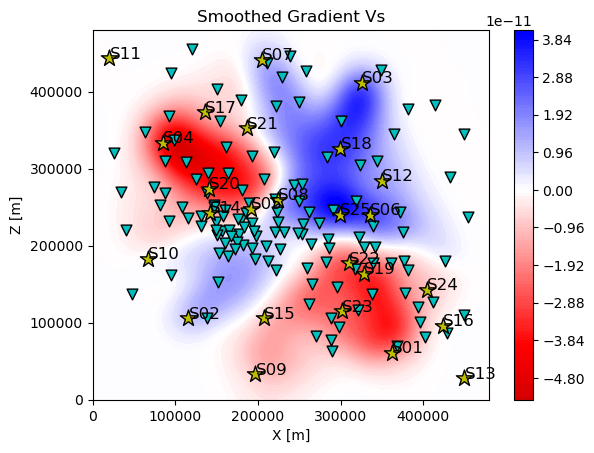

In [15]:
# SPECFEM Requires that some of the model files be discoverable alongside the kernels
! cp -f GRADIENT/*.bin DATA/

! mpirun -n 1 bin/xsmooth_sem 20000 20000 vs_kernel DATA/ GRADIENT/ .false.
! mpirun -n 1 bin/xsmooth_sem 20000 20000 vp_kernel DATA/ GRADIENT/ .false.

# The smoothing operation has created new files with the 'smooth' tag
vs_kernel_smooth = read_fortran_binary("GRADIENT/proc000000_vs_kernel_smooth.bin")

boundary_value = 8E-11  # <- change this value to adjust the colorscale

# Plot the kernel
plt.tricontourf(x, z, vs_kernel_smooth, levels=125, cmap="seismic_r", 
                vmin=-1*boundary_value, vmax=boundary_value)
plt.colorbar()

plot_sources_receivers()
plt.title("Smoothed Gradient Vs")

#### Understanding the above figure

- We have applied smoothing using a 2D Gaussian with half width equal to 20km
- The regularization has removed a lot of the small-scale heterogeneity present in the raw gradient  
- The colors still represent the same quantities as before  

-------------
## 8) Scaling the Gradient and Perturbing the Initial Model

- We need to **scale** the gradient before using it to perturb the initial model  
- We can use SeisFlows utility functions to read in the gradient files  

#### **TASKS TO COMPLETE:**
- Copy and adjust the PATHS and complete tasks in this code block before running it
- **Only** update seismic velocity Vp and Vs  (during your own research, other quantities may be updated)  


```python
# Copy and edit the code below
gradient_vp = read_fortran_binary(PATH_TO_ALPHA_SMOOTH)
gradient_vs = read_fortran_binary(PATH_TO_BETA_SMOOTH)

model_init_vp = read_fortran_binary(PATH_TO_MODEL_VP)
model_init_vs = read_fortran_binary(PATH_TO_MODEL_VS)

# TASKS TO COMPLETE HERE
# 1) SCALE the gradient so that it is at max 10% of the PEAK Vp or Vs value
# 2) SUBTRACT the gradient from its respective model in new parameters: 'model_01_vs', 'model_01_vp'
# 3) Match the formatting of the 'write' functions below, which will OVERWRITE our initial model

# Overwrites Vp and Vs for Model 01 with perturbed model parameters
write_fortran_binary(model_01_vp, "DATA/proc000000_vp.bin")
write_fortran_binary(model_01_vs, "DATA/proc000000_vs.bin")
```

In [16]:
# Load in the regularized kernel
vp_kernel = read_fortran_binary("GRADIENT/proc000000_vs_kernel_smooth.bin")
vs_kernel = read_fortran_binary("GRADIENT/proc000000_vs_kernel_smooth.bin")

# Load the initial model velocity so we can overload them
model_init_vp = read_fortran_binary("DATA/proc000000_vp.bin")
model_init_vs = read_fortran_binary("DATA/proc000000_vs.bin")

# The Gradient is a linear vector of kernels for each parameter
gradient = np.hstack((vp_kernel, vs_kernel))

# Split the gradient by parameter
n = len(gradient) // 2
gradient_vp = gradient[:n]
gradient_vs = gradient[n:]

# Calculate GTG^-1
max_alpha = model_init_vs.mean() * 0.1  
gradient /= gradient.max()  # reset gradient to be scaled to 1
gradient *= max_alpha  # set a new alpha value as 10% of the velocity model

# Perturb the initial model by the gradient
# !!! I missed a sign flip somewhere so it needs to come in here. Sorry! - Bryant !!!
model_01_vp = model_init_vp - (-1 * gradient_vp)
model_01_vs = model_init_vs - (-1 * gradient_vs)

# OVERWRITE Vp and Vs for Model 01 with perturbed model parameters
write_fortran_binary(model_01_vp, "DATA/proc000000_vp.bin")
write_fortran_binary(model_01_vs, "DATA/proc000000_vs.bin")

-----------------
## 9) Run Forward Simulations with Updated Model

- Now that we have a perturbed model (Model 01) we can use it to run forward simulations
- We'll calculate misfit for each of the new synthetics 
- We can compare the overall misfit of the initial model to Model 01


#### **TASKS TO COMPLETE:**

1) Tell SPECFEM that we want to run forward simulations again  
2) Tell SPECFEM that we want to use a 'gll' model (`model`=gll)
3) Choose one of your 10 events that you used to run your original forward simulations    
4) Run mesher and solver
5) Quantify misfit for each set of synthetics, save misfit to a text file (e.g., *'source_001_misfit_updated_model.txt'*)  
6) Repeat Steps 3-5 for all events  

In [17]:
# Reset the simulation type to forward, since we changed it during the adjoint simulation
! seisflows sempar -P DATA/Par_file simulation_type 1
! seisflows sempar -P DATA/Par_file model gll

run_fwd_mesher_solver(ntask=10, save_synthetics="SYNTHETIC_01", save_forward=False)
quantify_misfit(misfit_file="MISFIT_01.txt", write_adjsrc=False, syn_dir="SYNTHETIC_01")

SIMULATION_TYPE: 3 -> 1
MODEL: default -> gll
Generating synthetics for 10 sources
Running mesher and solver for SOURCE_001
Running mesher and solver for SOURCE_002
Running mesher and solver for SOURCE_003
Running mesher and solver for SOURCE_004
Running mesher and solver for SOURCE_005
Running mesher and solver for SOURCE_006
Running mesher and solver for SOURCE_007
Running mesher and solver for SOURCE_008
Running mesher and solver for SOURCE_009
Running mesher and solver for SOURCE_010
Finished generating synthetics
Quantifying misfit for SOURCE_001
	AA.S000000.BXY.semd; MISFIT=8.113E-05
	AA.S000001.BXY.semd; MISFIT=6.634E-05
	AA.S000002.BXY.semd; MISFIT=1.796E-05
	AA.S000003.BXY.semd; MISFIT=1.891E-04
	AA.S000004.BXY.semd; MISFIT=2.000E-05
	AA.S000005.BXY.semd; MISFIT=1.294E-05
	AA.S000006.BXY.semd; MISFIT=1.989E-05
	AA.S000007.BXY.semd; MISFIT=2.371E-04
	AA.S000008.BXY.semd; MISFIT=5.288E-06
	AA.S000009.BXY.semd; MISFIT=1.358E-04
Quantifying misfit for SOURCE_002
	AA.S000000.BXY.se

### 9a) Optional: Visualize Waveform Differences

#### **TASKS TO COMPLETE**
- Plot initial model synthetics against updated model synthetics for one or all synthetics, to check that waveforms have changed  

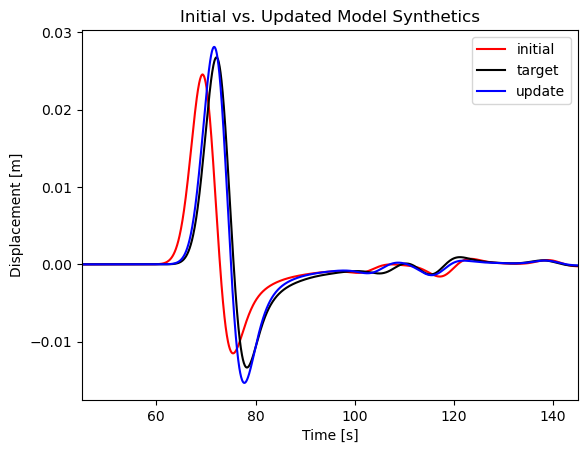

In [18]:
# Plot an example of data, synthetic and adjoint source
t_init, d_init = np.loadtxt("SOURCE_001/SYNTHETIC/AA.S000000.BXY.semd").T
t_true, d_true = np.loadtxt("SOURCE_001/TARGET/AA.S000000.BXY.semd").T
t_m01, d_m01 = np.loadtxt("SOURCE_001/SYNTHETIC_01/AA.S000000.BXY.semd").T 

plot_waveforms(t=t_init, data=[d_init, d_true, d_m01],
               labels=["initial", "target", "update"],
               colors=["r", "k", "b"])

plt.title("Initial vs. Updated Model Synthetics")
plt.xlim([45, 145])
plt.show()

----------------
## 10) Compare Misfit between Initial and Updated models
- Now we have two files containing misfit, one for the initial model, and one for the updated model (M01)  
- Each line in the misfit file corresponds to the overall misfit for a single event  
- We can compare them by taking the average of all lines in the misfit file  


#### **TASKS TO COMPLETE:**
1) Gather all misfit text files for your initial model
2) For one given event, read in the text file and sum all the lines in the file (summing misfit from all stations)  
3) Divide this value by the number of stations (or number of lines)  
4) Repeat steps 1-3 for all events  
5) Sum all values gathered in (4) 
6) Divide number retrieved in line 5 by the number of events  
7) Repeat Steps 1-6 for updated model
8) Compare recovered misfit value between initial and updated model  

In [19]:
# Calculate misfit from each source
misfit_init, misfit_m01 = [], []

for src in sorted(glob("SOURCE_???")):
    m_init = np.loadtxt(os.path.join(src, "MISFIT_INIT.txt"))
    m_01 = np.loadtxt(os.path.join(src, "MISFIT_01.txt"))
    
    misfit_init.append(m_init.sum() / len(m_init))
    misfit_m01.append(m_01.sum() / len(m_01))
    
total_misfit_init = sum(misfit_init) / len(misfit_init)
total_misfit_m01 = sum(misfit_m01) / len(misfit_m01)

print(f"MISFIT INITIAL MODEL = {total_misfit_init}")
print(f"MISFIT UPDATED MODEL = {total_misfit_m01}")
print(f"MISFIT REDUCED? -> {bool(total_misfit_init > total_misfit_m01)}")

MISFIT INITIAL MODEL = 0.0008597683006224604
MISFIT UPDATED MODEL = 0.00015832073665032368
MISFIT REDUCED? -> True
